## 📰 **Detecting Political Bias in Indian News Media**


**This project analyzes political bias in Indian news articles by scraping real-time data, cleaning and visualizing it, and training MiniLM model to detect leanings (left, right, center).**

- Project By: Prashant Pramod Patil



## 🎯 **Objective**
- Detect and classify political bias in Indian news using NLP.
- Use transformer models like MiniLM for robust classification.
- Visualize patterns in headlines and sentiment across different media outlets.

## 🤔 **Why This Project?**
- India has a diverse and polarized media landscape.
- Political bias in reporting can shape public opinion.
- Analyzing it with data and ML can uncover patterns and trends.


In [4]:
#Data handling
import pandas as pd
import numpy as np


#Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Train/test split and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

#Hugging face transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import transformers

#Hugging face datasets (for tokenization)
from datasets import Dataset


from google.colab import drive
drive.mount('/content/drive')

print("Libraries loaded successfully.")


Mounted at /content/drive
Libraries loaded successfully.


##**Loading the data**

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NewsArticleData.csv')
print(df.shape)
df.head()

(600, 6)


,title,description,published_date,source,bias_text,label
0,India Ranks 5th in Global GDP List,IMF figures indicate positive trajectory.,27-06-2025,Mint,center,1
1,RBI Keeps Repo Rate Unchanged,Monetary policy committee evaluates inflation ...,24-06-2025,PTI,center,1
2,Refugees Face Statelessness Under New Policy,UN says new rules violate humanitarian princip...,11-06-2025,Scroll.in,left,0
3,SEBI Introduces New IPO Norms,Reforms aim to protect retail investors.,19-06-2025,Indian Express,center,1
4,Disability Pension Budget Slashed,Critics say social justice is being undermined.,27-06-2025,The Hindu,left,0


##**Checking for null values**





In [4]:
df.isnull().sum()

,0
title,0
description,0
published_date,0
source,0
bias_text,0


##**Checking the size of each category**

In [5]:
print(df['bias_text'].value_counts())

bias_text
center    197
left      197
right     195
Right       5
Center      3
Left        3
Name: count, dtype: int64


##**There are inconsistencies in spellings of bias_text so we will lower all the fields from that column to Lowercase**

In [6]:
df['bias_text'] = df['bias_text'].str.lower()
print(df['bias_text'].value_counts())

bias_text
center    200
left      200
right     200
Name: count, dtype: int64


##**The data is well distributed among each category so there is no need for downsampling or upsampling**

/tmp/ipython-input-7-801451650.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=bias_counts.index, y=bias_counts.values, palette=["red", "green", "blue"])


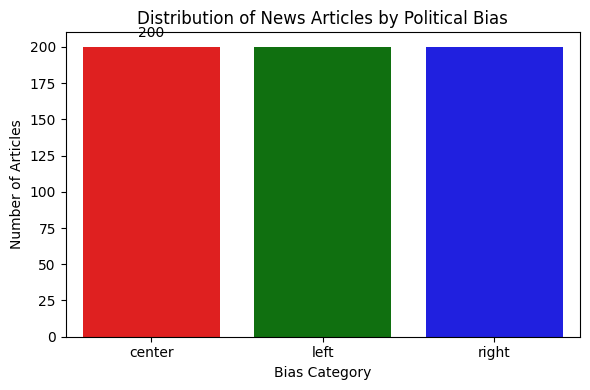

In [7]:
bias_counts = df['bias_text'].value_counts().sort_index()

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=bias_counts.index, y=bias_counts.values, palette=["red", "green", "blue"])

ax.bar_label(ax.containers[0], padding=5, fontsize=10)

ax.set_title("Distribution of News Articles by Political Bias", fontsize=12)
ax.set_xlabel("Bias Category", fontsize=10)
ax.set_ylabel("Number of Articles", fontsize=10)

plt.tight_layout()
plt.show()



##**We will create a label column which will indicate the bias as  (left=0, center=1, right=2)**

In [8]:
label_map = {'left': 0, 'center': 1, 'right': 2}

df['label'] = df['bias_text'].map(label_map)
df.head()
print(df['label'].value_counts())


label
1    200
0    200
2    200
Name: count, dtype: int64


##**We will merge the title and description column by creating a text column.(it will help to tokenize the data)**

In [9]:
df['text'] = df['title'] +" "+df['description']

#we will lower the text from text column also

df['text'] = df['text'].str.lower()
df.head()

,title,description,published_date,source,bias_text,label,text
0,India Ranks 5th in Global GDP List,IMF figures indicate positive trajectory.,27-06-2025,Mint,center,1,india ranks 5th in global gdp list imf figures...
1,RBI Keeps Repo Rate Unchanged,Monetary policy committee evaluates inflation ...,24-06-2025,PTI,center,1,rbi keeps repo rate unchanged monetary policy ...
2,Refugees Face Statelessness Under New Policy,UN says new rules violate humanitarian princip...,11-06-2025,Scroll.in,left,0,refugees face statelessness under new policy u...
3,SEBI Introduces New IPO Norms,Reforms aim to protect retail investors.,19-06-2025,Indian Express,center,1,sebi introduces new ipo norms reforms aim to p...
4,Disability Pension Budget Slashed,Critics say social justice is being undermined.,27-06-2025,The Hindu,left,0,disability pension budget slashed critics say ...


##**Now we will split the data to train and test. we will only need the following columns for the model:**
- text
- label

In [10]:
X = df['text']
y = df['label']

train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
print("Training examples: ",train_texts.shape)
print("Test examples: ",val_texts.shape)


Training examples:  (480,)
Test examples:  (120,)


##**Tokenize Text Using MiniLM Tokenizer**
We’ll use Hugging Face’s AutoTokenizer to tokenize the input text using the MiniLM model

In [11]:
model_checkpoint = "microsoft/MiniLM-L12-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

#Tokenize train and Test sets
def tokenize(batch):
    return tokenizer(batch, padding='max_length', truncation=True, max_length=128)

train_texts = list(train_texts)
val_texts = list(val_texts)

#Apply tokenization
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

##**Convert Tokenized Data into Hugging Face Dataset Format**
Because Hugging face trainer expects data in a special format to train the model

In [29]:
#Creating training dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'label': train_labels
})

#Creating test dataset
val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'label': val_labels
})

##**Load MiniLM Model & Define Training Arguments**

In [30]:


# Load MiniLM model with 3 output labels for bias classification
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/MiniLM-L12-H384-uncased",
    num_labels=3
)

# Define training arguments (no push to hub or reporting)
training_args = TrainingArguments(
    output_dir="./results",              # Where to save model checkpoints
    num_train_epochs=4,                  # Number of epochs
    per_device_train_batch_size=16,      # Training batch size
    per_device_eval_batch_size=64,       # Evaluation batch size
    learning_rate=2e-5,                  # Learning rate
    weight_decay=0.01,                   # Regularization
    logging_dir="./logs",                # Logging directory
    report_to="none"                     # Disable integration with any logging service
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##**Training the model**

In [16]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=120, training_loss=0.7913414001464844, metrics={'train_runtime': 13.9745, 'train_samples_per_second': 137.393, 'train_steps_per_second': 8.587, 'total_flos': 6175679328000.0, 'train_loss': 0.7913414001464844, 'epoch': 4.0})

##**Model Accuracy on Test data**

In [18]:
predictions = trainer.predict(val_dataset)

preds = predictions.predictions.argmax(axis=1)
true = predictions.label_ids

accuracy = accuracy_score(true, preds)
print("test Accuracy:", round(accuracy * 100, 2), "%")

#the reason of 100% accuracy can be repeated fields as i collected data of the same news from different sources. so the wording can be same

Validation Accuracy: 100.0 %


#**Simple prediction model**

In [28]:
def predict_bias(title, description):
    # Combine title and description
    input_text = title + ". " + description

    # Tokenize and move to the same device as model (GPU or CPU)
    inputs = tokenizer(
        input_text,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    ).to(model.device)  # <-- Move to model's device

    # Get prediction
    outputs = model(**inputs)
    predicted_label = outputs.logits.argmax(dim=1).item()

    # Map label to class name
    label_map = {0: "Left", 1: "Center", 2: "Right"}
    return label_map[predicted_label]

title_input = input("Enter the news title: ")
description_input = input("Enter the news description: ")

predicted_bias = predict_bias(title_input, description_input)
print("\nPredicted Political Bias:", predicted_bias)



Enter the news title: Odisha: Bureaucrats Go On Mass Leave to Protest Officer’s Assault, Demand BJP Leader’s Arrest
Enter the news description: The police have arrested five persons in connection with the matter including BMC corporator Jeevan Rout, who is also a BJP member.

Predicted Political Bias: Left
